In [1]:
%load_ext autoreload
%autoreload 2
%aimport -decode_fish.engine.place_psfs

In [2]:
# export
from decode_fish.imports import *

# os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.evaluation import *

from decode_fish.funcs.visualization import *

from omegaconf import open_dict
from hydra import compose, initialize
from decode_fish.funcs.merfish_eval import *

import h5py
from decode_fish.funcs.routines import *

initialize(config_path="../config")

hydra.initialize()

## Generate Data for internal comparison

In [358]:
cfg = compose(config_name='train.yaml', overrides= ["+exp_type=merfish_MOp"])
# cfg = OmegaConf.create(cfg)

In [359]:
thetas = 1.
channel_facs = [1.] * 22

cfg.data_path.image_path = cfg.base_dir + '/datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_scaled_images151.tif'

cfg.genm.foci.n_foci_avg = 0

cfg.genm.prob_generator.low = 0.02
cfg.genm.prob_generator.high = 0.05

cfg.genm.PSF.n_cols = 1
cfg.genm.microscope.ch_cols = [0] * 22

cfg.genm.noise.theta = thetas
cfg.genm.microscope.ch_facs = channel_facs
cfg.genm.microscope.col_shifts_enabled = False

cfg.sim.roi_mask.percentile = 20
cfg.sim.random_crop.crop_sz = 512

cfg.sim.bg_estimation.smoothing.smoothing_filter_size = 9
cfg.sim.bg_estimation.type = 'smoothing'

cfg.genm.intensity_dist.int_conc = 8
cfg.genm.intensity_dist.int_rate = 1.
cfg.genm.intensity_dist.int_loc = 2.

cfg.genm.microscope.scale = 5000
cfg.genm.phasing = 0.0
cfg.sim.bg_estimation.fractal.scale = 0

cfg.data_path.psf_path = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/figures/chall_ds_psf_onesided_normed.tif'
cfg.genm.microscope.norm = 'none'
cfg.genm.PSF.mode = 'bicubic'

cfg.genm.emitter_noise.rate_fac = 3.
cfg.genm.emitter_noise.int_fac = 1.

cfg.network.is_2D = True

In [360]:
psf, noise, micro = load_psf_noise_micro(cfg)

In [361]:
state_dict = micro.state_dict()
ch_shifts = torch.randn(micro.channel_shifts.shape) * 0.15
ch_shifts[:,2] *= 0.
state_dict['channel_shifts'] = ch_shifts
micro.load_state_dict(state_dict)

<All keys matched successfully>

In [369]:
out_dir = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_int_5_osc/'
!mkdir '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_int_5_osc/'

In [363]:
cfg.training.bs = 1
_, decode_dl = get_dataloader(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 512, 512)
7 volumes


In [364]:
codebook, targets = hydra.utils.instantiate(cfg.codebook)

In [365]:
from decode_fish.funcs.routines import *
from decode_fish.engine.point_process import *
from decode_fish.engine.microscope import *
from decode_fish.funcs.output_trafo import sample_to_df

def sim_data(decode_dl, micro, batches, int_conc=4., int_rate=1., int_loc=.5, channels=1, n_bits=1, codebook=None, rate_fac=1., pos_noise_xy=0., pos_noise_z=0., 
             emitter_noise_rate_fac=0, emitter_noise_int_fac=0, const_theta_sim=True, int_option=1):
    
    gt_dfs = []
    xsim_col = []
    cols_col = []
    bg_col = []

    for _ in range(batches):
        with torch.no_grad():
            ret_dict = next(iter(decode_dl))
            x, local_rate, background = ret_dict['x'], ret_dict['local_rate'], ret_dict['background'], 
            if micro.col_shifts_enabled:
                zcrop, ycrop, xcrop = ret_dict['crop_z'], ret_dict['crop_y'], ret_dict['crop_x']
                zcrop, ycrop, xcrop = zcrop.flatten(), ycrop.flatten(), xcrop.flatten()
            else:
                zcrop, ycrop, xcrop, colshift_crop = None, None, None, None
                
            background = background * micro.get_ch_mult()
            local_rate *= rate_fac
            
            sim_vars = PointProcessUniform(local_rate[:,0], int_conc, int_rate, int_loc, channels=channels, n_bits=n_bits, sim_z=micro.slice_rec, codebook=codebook, int_option=int_option).sample(from_code_book=(codebook is not None))
            ch_inp = list(micro.get_single_ch_inputs(*sim_vars[:-1], ycrop=ycrop, xcrop=xcrop))
            if pos_noise_xy or pos_noise_z:
                ch_inp[1:4] = add_pos_noise(ch_inp[1:4], [pos_noise_xy, pos_noise_xy, pos_noise_z], n_bits)
            xsim = micro(*ch_inp, add_noise=True)

            if emitter_noise_rate_fac:
                noise_vars = PointProcessUniform(local_rate[:,0] * emitter_noise_rate_fac, int_conc=int_conc * emitter_noise_int_fac, 
                                               int_rate=int_rate, int_loc=int_loc, 
                                               sim_iters=5, channels=channels, n_bits=1, 
                                               sim_z=micro.slice_rec, codebook=None, int_option=int_option).sample(from_code_book=False)     

                noise_inp = micro.get_single_ch_inputs(*noise_vars[:-1], ycrop=ycrop, xcrop=xcrop)
                background += micro(*noise_inp, add_noise=True)
        
            x = micro.noise(xsim, background, const_theta_sim=const_theta_sim).sample()

            if micro.col_shifts_enabled:
                colshift_crop = get_color_shift_inp(micro.color_shifts, micro.col_shifts_yx, ycrop, xcrop, decode_dl.dataset.dataset_tfms[0].crop_sz[-1])
                net_inp = torch.concat([x,colshift_crop], 1)
                cols_col.append(colshift_crop)
                
            xsim_col.append(x)
            bg_col.append(background)

            gt_vars = sim_vars[:-2] 
            gt_df = sample_to_df(*gt_vars, sim_vars[-1], px_size_zyx=[1.,1.,1.])
            gt_dfs.append(gt_df)
        
    cols_col = torch.cat(cols_col) if micro.col_shifts_enabled else None
        
    return torch.cat(xsim_col), torch.cat(bg_col), cols_col, cat_emitter_dfs(gt_dfs, decode_dl.batch_size)

In [366]:
xsim, bg, cols, gt_df = sim_data(decode_dl, micro, 10, 
                          int_conc=cfg.genm.intensity_dist.int_conc, int_rate=cfg.genm.intensity_dist.int_rate, int_loc=cfg.genm.intensity_dist.int_loc,
                          channels=22, n_bits=4, codebook=torch.tensor(codebook), rate_fac=1., 
                          pos_noise_xy=cfg.genm.pos_noise.pos_noise_xy, pos_noise_z=cfg.genm.pos_noise.pos_noise_z, 
                          emitter_noise_rate_fac=cfg.genm.emitter_noise.rate_fac, emitter_noise_int_fac=cfg.genm.emitter_noise.int_fac
                         )

gt_df = px_to_nm(gt_df)
gt_df = exclude_borders(gt_df, border_size_zyx=[0,500,500], img_size=[cfg.sim.random_crop.crop_sz*100,cfg.sim.random_crop.crop_sz*100,cfg.sim.random_crop.crop_sz*100])

In [367]:
channel_facs = torch.randn(micro.channel_facs.shape) * 0.15 + 1

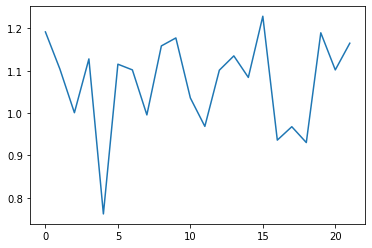

In [368]:
plt.plot(cpu(channel_facs))

In [370]:
xsim = xsim / channel_facs[None,:,None,None,None].cuda()
bg = bg / channel_facs[None,:,None,None,None].cuda()

In [371]:
state_dict = micro.state_dict()
state_dict['channel_facs'] = channel_facs
micro.load_state_dict(state_dict)

<All keys matched successfully>

In [372]:
torch.save(micro.state_dict(), out_dir+'microscope.pkl')

In [375]:
xsim.max()

tensor(23880.0977, device='cuda:0')

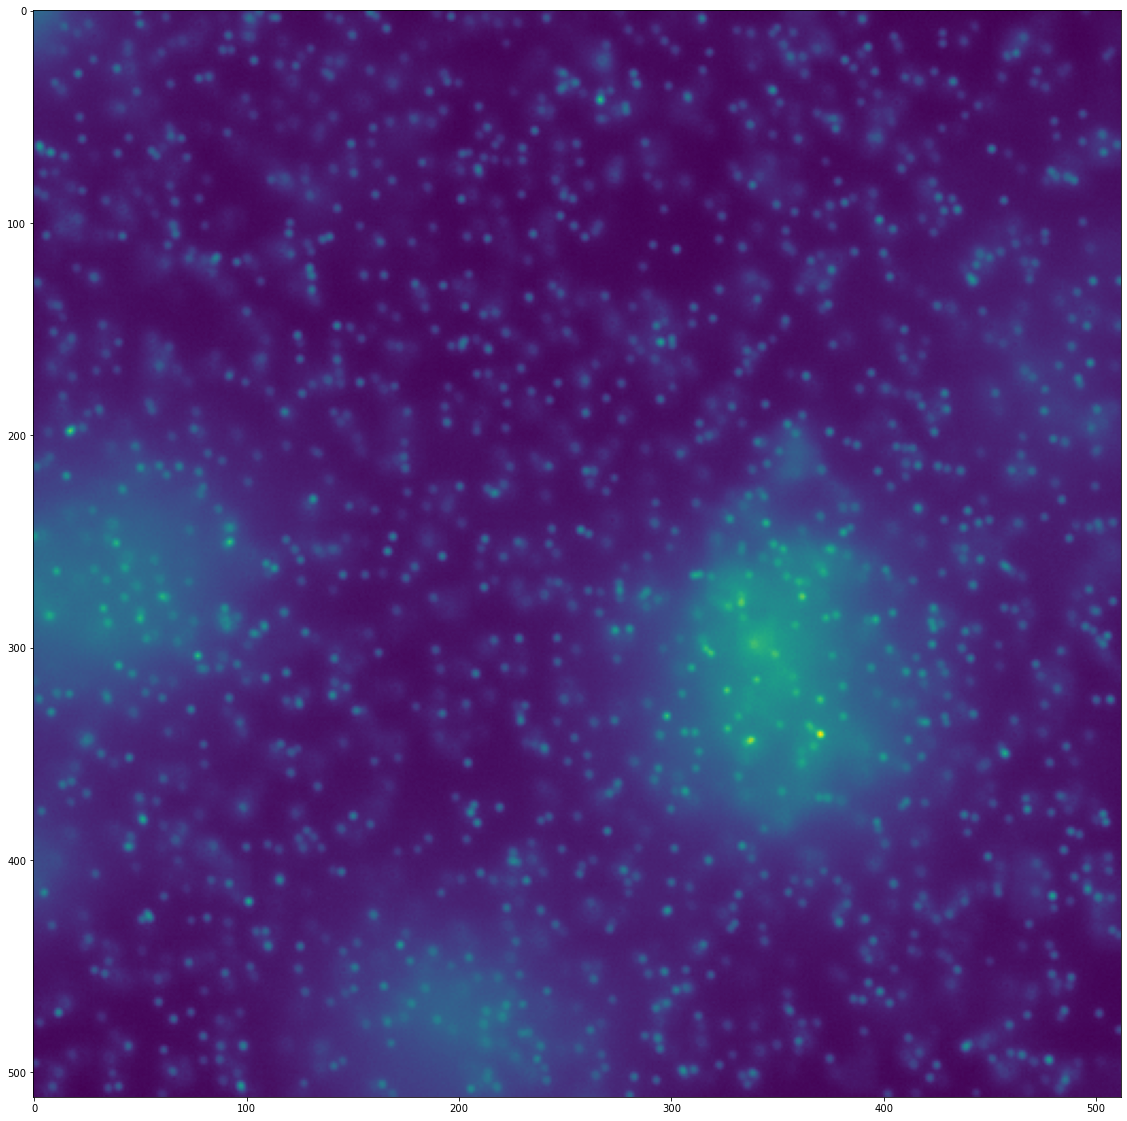

In [376]:
plt.figure(figsize=(20,20))
plt.imshow(cpu(xsim[1,11,0]))

In [377]:
with h5py.File(out_dir+'images.h5', 'w') as f:
    
    add_df_to_hdf5(f, 'locations', gt_df)          
    f.create_dataset('frames', data=cpu(xsim))
    f.create_dataset('background', data=cpu(bg))

import tifffile
tifffile.imsave(out_dir+'images.tiff', data=cpu(xsim))

In [405]:
out_dir = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_int_5_osc/'
with h5py.File(out_dir+'images.h5', 'r') as f:
    
    gt_df = get_df_from_hdf5(f['locations'])  
    frames = f['frames'][()]

In [639]:
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_sim_int/sim_int_5_osc/ae_train_l1//train.yaml')
cfg.genm.PSF.psf_extent_zyx=11

In [542]:
cfg_files = glob.glob('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_sim_int/sim_int_5_osc/*/train.yaml')

In [543]:
cfg_files

['/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_sim_int/sim_int_5_osc/ae_train_l1/train.yaml',
 '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_sim_int/sim_int_5_osc/sl_true_gen_mae/train.yaml',
 '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_sim_int/sim_int_5_osc/sl_no_learn/train.yaml',
 '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_sim_int/sim_int_5_osc/ae_train_noembgp/train.yaml',
 '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_sim_int/sim_int_5_osc/ae_train_mae/train.yaml',
 '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_sim_int/sim_int_5_osc/sl_true_gen_noembgp/train.yaml']

In [640]:
codebook, targets = hydra.utils.instantiate(cfg.codebook)

In [641]:
# Load the model, post processing, imgages, dataloader
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)
psf_vol = cpu(micro.psf.psf_volume)
# psf_init = cpu(micro.psf_init_vol)
post_proc.codebook = torch.tensor(codebook)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 56, 56)
10 volumes


0.9929359170504614
0.9837988957607455
0.9753596280745831
nan


/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Text(0.5, 0, 'Round')

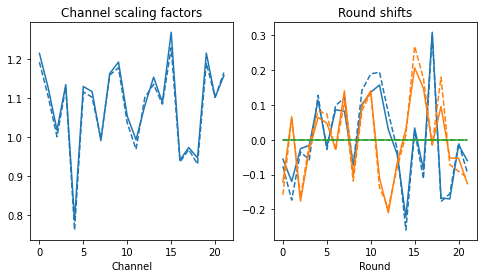

In [565]:
import seaborn as sns
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(8, 4))
cmap = sns.color_palette("tab10")

ax1.plot(cpu(micro_init.channel_facs), color=cmap[0], linestyle='--')
ax1.plot(cpu(micro.channel_facs), color=cmap[0])
ax1.set_title('Channel scaling factors')
ax1.set_xlabel('Channel')
print(np.corrcoef(cpu(micro.channel_facs), cpu(micro_init.channel_facs))[0,1])

labels = ['x','y','z']
for i in range(3):
    ax2.plot(cpu(micro.channel_shifts[:,i]), label=labels[i], color=cmap[i])
    ax2.plot(cpu(micro_init.channel_shifts[:,i] - micro_init.channel_shifts[:,i].mean()), label=labels[i], linestyle='--', color=cmap[i])
    print(np.corrcoef(cpu(micro.channel_shifts[:,i]), cpu(micro_init.channel_shifts[:,i]))[0,1])
ax2.set_title('Round shifts')
ax2.set_xlabel('Round')

In [566]:
gt_psf = load_tiff_image('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/figures/chall_ds_psf_onesided_normed.tif')

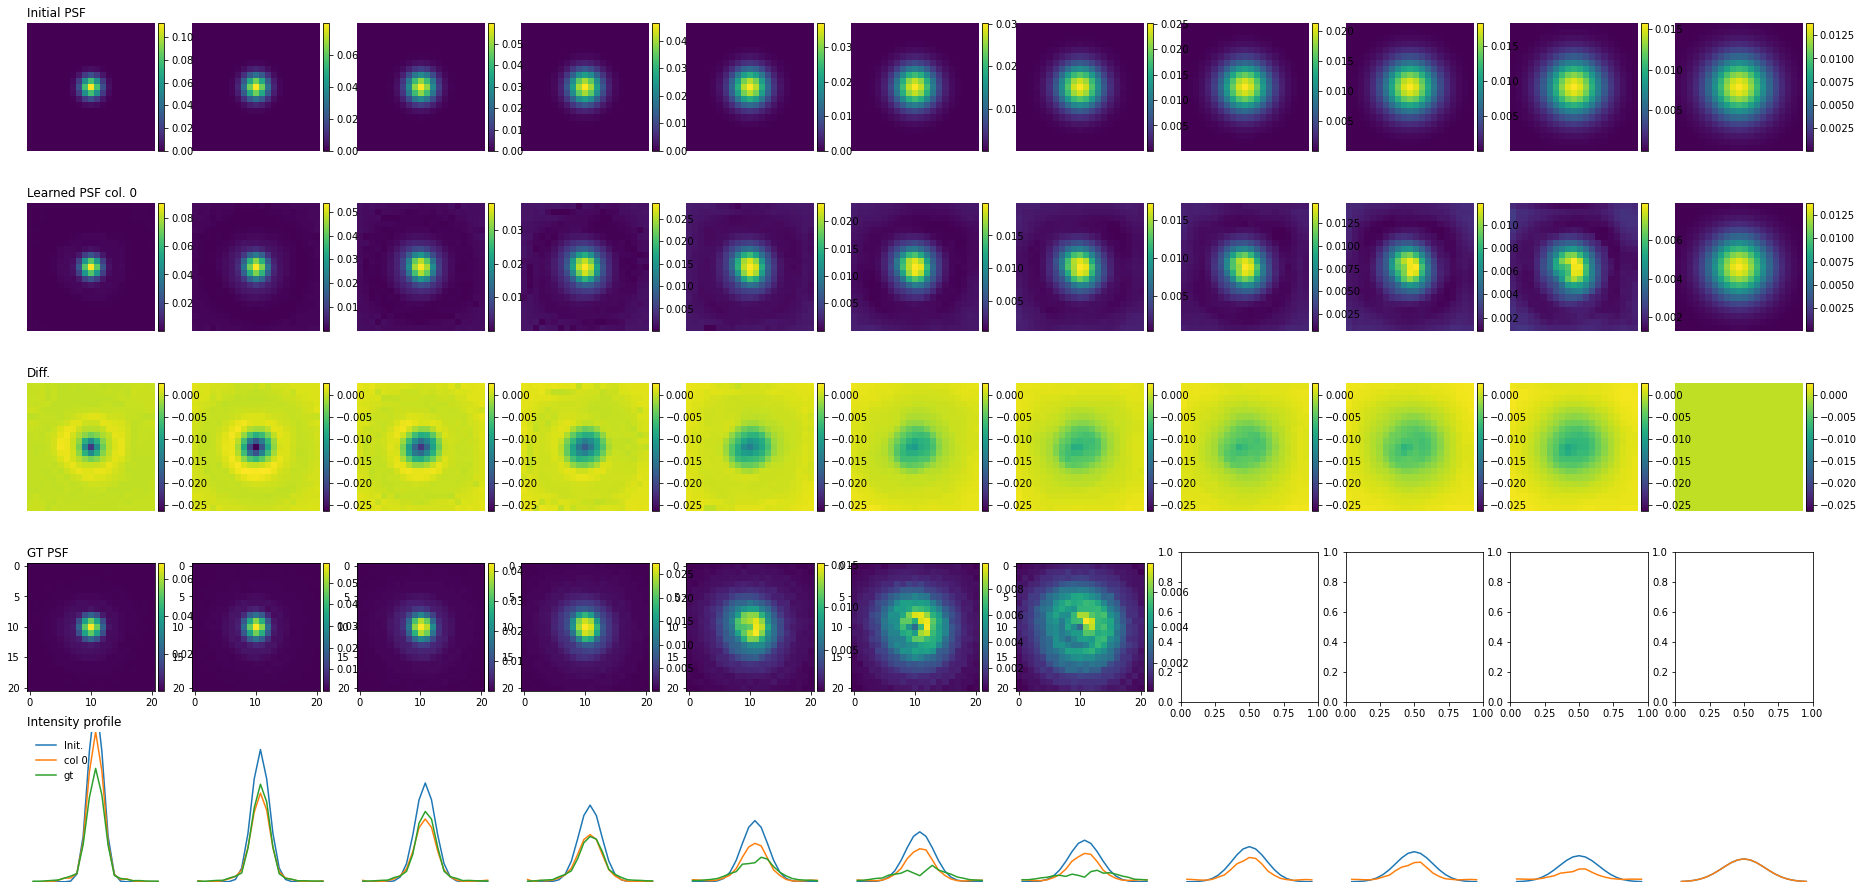

In [567]:
plot_slice_psf_pars(micro, gt_psf[None], normed=True)

In [548]:
from decode_fish.funcs.predict import window_predict
df_dict = {}
for file in [cfg_files[i] for i in range(len(cfg_files))]:
    k = file.split('/')[-2]
    print(k)
#     if k not in df_dict:
    cfg = OmegaConf.load(file)
    if 'true' not in k:
        cfg.genm.PSF.psf_extent_zyx=11
    model = load_model_state(model, Path(cfg.output.save_dir)/'model.pkl').cuda()
    psf, noise, micro = load_psf_noise_micro(cfg)
    
    micro.load_state_dict(torch.load(Path(cfg.output.save_dir)/'microscope.pkl'), strict=False)
    res_df = window_predict(model, post_proc, torch.tensor(frames), window_size=[None, 128, 128], device='cuda', chrom_map=None, scale=micro.get_ch_mult(), progress_bar=True)
    res_df = exclude_borders(res_df, border_size_zyx=[0,500,500], img_size=[512*100,512*100,512*100])  
    df_dict[k] = res_df

ae_train_l1
torch.Size([10, 22, 1, 512, 512])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:42<00:00,  4.25s/it]


sl_true_gen_mae
torch.Size([10, 22, 1, 512, 512])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:41<00:00,  4.18s/it]


sl_no_learn
torch.Size([10, 22, 1, 512, 512])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.06s/it]


ae_train_noembgp
torch.Size([10, 22, 1, 512, 512])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:39<00:00,  3.99s/it]


ae_train_mae
torch.Size([10, 22, 1, 512, 512])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:41<00:00,  4.19s/it]


sl_true_gen_noembgp
torch.Size([10, 22, 1, 512, 512])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:41<00:00,  4.16s/it]


ae_train_l1 0.15219474323936902
sl_true_gen_mae 0.06558760614059908
sl_no_learn 0.759928798469285
ae_train_noembgp 0.10328166125510271
ae_train_mae 0.14465034308369717
sl_true_gen_noembgp 0.0629422216240301


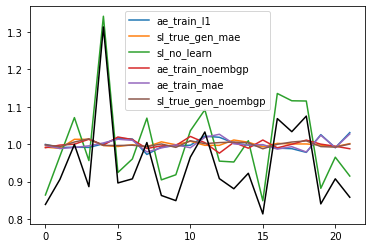

In [549]:
for k in df_dict:
    int_arr = zero_int_ch(df_dict[k].nsmallest(15000, 'comb_sig'), codebook)[[f'int_{i}' for i in range(codebook.shape[1])]].values
    ch_means = [int_arr[:,i].sum()/(int_arr[:,i] != 0).sum() for i in range(22)]
    print(k, np.sqrt(np.var(ch_means)))
    
    plt.plot(ch_means/np.mean(ch_means), label=k)
plt.plot(1/channel_facs, color='black')
plt.legend()

In [283]:
int_arr = zero_int_ch(df_dict['ae_train'].nsmallest(15000, 'comb_sig'), codebook)[[f'int_{i}' for i in range(codebook.shape[1])]].values
ch_means = [int_arr[:,i].sum()/(int_arr[:,i] != 0).sum() for i in range(22)]
print(k, np.sqrt(np.var(ch_means)))

sl_nolearn 0.18554928866803166


In [412]:
for k in df_dict.keys():
    print(k, len(df_dict[k]))

sl_true_gen_mae 56202
sl_no_learn 27824
ae_train_mae 56448


In [550]:
perf_df = pd.DataFrame()
match_dict = {}

for k in df_dict.keys():
    print(k)
    perf, matches, _ = matching(gt_df, df_dict[k], print_res=True, tolerance=500, ignore_z=True)
    df_dict[k].loc[:, 'class'] = 1
    df_dict[k].loc[df_dict[k]['loc_idx'].isin(matches['loc_idx_pred']), 'class'] = 0    
    
    perf_df[k] = pd.Series(perf)
    match_dict[k] = matches

ae_train_l1
Recall: 0.645
Precision: 0.860
Jaccard: 58.371
RMSE_vol: 54.419
Eff_3d: 50.267
FN: 28273.0 FP: 8363.0
Num. matches: 51369.000
Shift: -29.04,11.60,24.87
sl_true_gen_mae
Recall: 0.675
Precision: 0.958
Jaccard: 65.530
RMSE_vol: 24.243
Eff_3d: 63.461
FN: 25906.0 FP: 2360.0
Num. matches: 53736.000
Shift: 0.80,0.17,-1.28
sl_no_learn
Recall: 0.368
Precision: 0.992
Jaccard: 36.716
RMSE_vol: 34.542
Eff_3d: 34.402
FN: 50310.0 FP: 246.0
Num. matches: 29332.000
Shift: -14.57,4.62,27.00
ae_train_noembgp
Recall: 0.570
Precision: 0.924
Jaccard: 54.498
RMSE_vol: 49.131
Eff_3d: 48.290
FN: 34211.0 FP: 3721.0
Num. matches: 45431.000
Shift: -22.28,6.06,21.94
ae_train_mae
Recall: 0.627
Precision: 0.886
Jaccard: 58.052
RMSE_vol: 52.855
Eff_3d: 50.421
FN: 29685.0 FP: 6414.0
Num. matches: 49957.000
Shift: -28.59,12.87,25.42
sl_true_gen_noembgp
Recall: 0.664
Precision: 0.957
Jaccard: 64.442
RMSE_vol: 24.883
Eff_3d: 62.328
FN: 26783.0 FP: 2384.0
Num. matches: 52859.000
Shift: 0.54,-0.11,-1.30


In [539]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

keys = ['comb_sig','int_ratio','z']

for k in df_dict.keys():
    dfc = sel_int_ch(df_dict[k], codebook)
    X = np.concatenate([dfc[keys].values])
    y = np.concatenate([dfc['class'].values])

    clf = LogisticRegression(random_state=1,max_iter=10000, class_weight='balanced').fit(X, y)
    
    df_dict[k]['score'] = clf.predict_proba(X)[:,1]

(0.0, 1000.0)

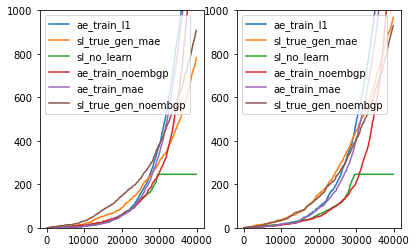

In [551]:
plt.figure(figsize=(10,4))
plt.subplot(131)
for k in df_dict:    
    df_c = df_dict[k].copy()
    df_c = sel_int_ch(df_c, codebook)
    r  = make_roc(df_c, 'comb_sig', n_max=40000, ascending=True)
    plt.plot(r[0],r[1], label=k)

plt.legend()
plt.ylim(0,1000)

plt.subplot(132)
for k in df_dict:    
    df_c = df_dict[k].copy()
    df_c = sel_int_ch(df_c, codebook)
    r  = make_roc(df_c, 'int_ratio', n_max=40000, ascending=True)
    plt.plot(r[0],r[1], label=k)

plt.legend()
plt.ylim(0,1000)

# plt.subplot(133)
# for k in df_dict:    
#     df_c = df_dict[k].copy()
#     df_c = sel_int_ch(df_c, codebook)
#     r  = make_roc(df_c, 'score', n_max=40000, ascending=True)
#     plt.plot(r[0],r[1], label=k)

# plt.legend()
# plt.ylim(0,1000)

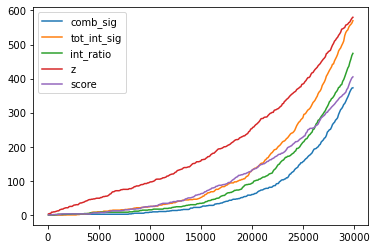

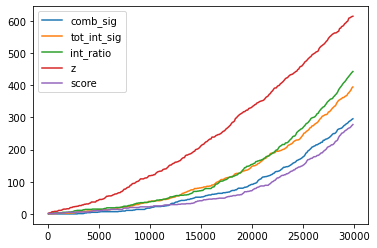

In [541]:
df_c = sel_int_ch(df_dict['ae_train_l1'], codebook)

for k in ['comb_sig','tot_int_sig', 'int_ratio', 'z','score']:
    b = False if k in ['tot_int','prob'] else True
    r  = make_roc(df_c, k, n_max=30000, ascending=b)
    plt.plot(r[0],r[1], label=k)
    
plt.legend()
plt.show()
df_c = sel_int_ch(df_dict['sl_true_gen_mae'], codebook)

for k in ['comb_sig','tot_int_sig', 'int_ratio', 'z','score']:
    b = False if k in ['tot_int','prob'] else True
    r  = make_roc(df_c, k, n_max=30000, ascending=b)
    plt.plot(r[0],r[1], label=k)
    
plt.legend()

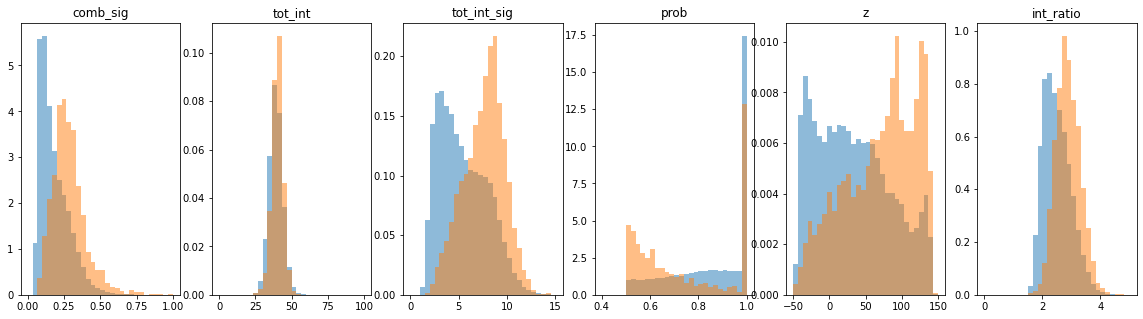

In [517]:
cdf = sel_int_ch(df_dict['sl_true_gen_mae'], codebook)

metrics = ['comb_sig','tot_int','tot_int_sig', 'prob','z', 'int_ratio']
bins = [np.linspace(0,1.,31), np.linspace(0,100,31), np.linspace(0,15,31), np.linspace(0.4,1,31), np.linspace(-50,150.,31),  np.linspace(0.,5., 31)]
plt.figure(figsize=(20,5))
for i in range(len(metrics)):
    plt.subplot(1,len(metrics),i+1)
    _=plt.hist(cdf[cdf['class'] == 0][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='gene matches')
    _=plt.hist(cdf[cdf['class'] == 1][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='blank matches')
    plt.title(metrics[i])

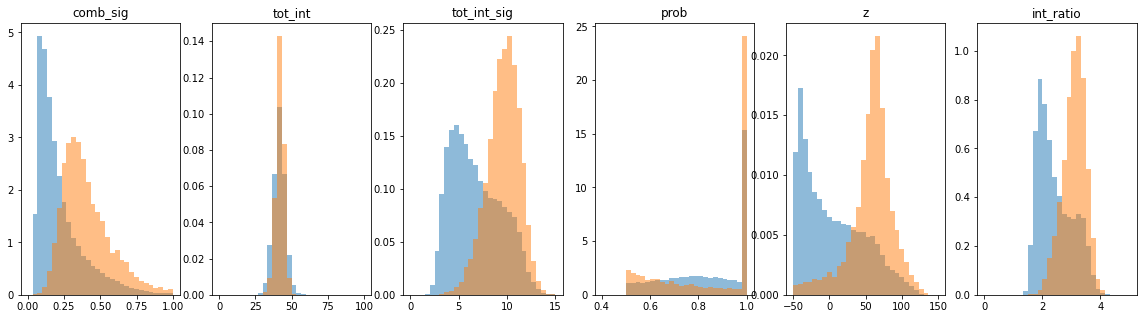

In [519]:
cdf = sel_int_ch(df_dict['ae_train_l1'], codebook)

metrics = ['comb_sig','tot_int','tot_int_sig', 'prob','z', 'int_ratio']
bins = [np.linspace(0,1.,31), np.linspace(0,100,31), np.linspace(0,15,31), np.linspace(0.4,1,31), np.linspace(-50,150.,31),  np.linspace(0.,5., 31)]
plt.figure(figsize=(20,5))
for i in range(len(metrics)):
    plt.subplot(1,len(metrics),i+1)
    _=plt.hist(cdf[cdf['class'] == 0][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='gene matches')
    _=plt.hist(cdf[cdf['class'] == 1][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='blank matches')
    plt.title(metrics[i])

In [53]:
# from decode_fish.funcs.routines import *
from decode_fish.funcs.routines import *
xsim, cols, gt = sim_data(decode_dl, micro, 5, 
                          int_conc=model.int_dist.int_conc.detach(), int_rate=model.int_dist.int_rate.detach(), int_loc=model.int_dist.int_loc.detach(),
                          channels=22, n_bits=4, codebook=torch.tensor(codebook), rate_fac=1., 
                          pos_noise_xy=cfg.genm.pos_noise.pos_noise_xy, pos_noise_z=cfg.genm.pos_noise.pos_noise_z, 
                          emitter_noise_rate_fac=cfg.genm.emitter_noise.rate_fac, emitter_noise_int_fac=cfg.genm.emitter_noise.int_fac
                         )

In [54]:
pred_dfs = []
net_inp = torch.concat([xsim], 1)
for i in range(len(net_inp)):
    pred_df = get_prediction(model, net_inp[i:i+1], post_proc, cuda=True)
    pred_dfs.append(pred_df)

pred_df = cat_emitter_dfs(pred_dfs)

In [55]:
perf, matches, _ = matching(px_to_nm(gt, cfg.evaluation.px_size_zyx), pred_df, tolerance=1000, print_res=True, match_genes=True, allow_multiple_matches=False)

Recall: 0.402
Precision: 0.903
Jaccard: 38.582
RMSE_vol: 63.369
Eff_3d: 30.891
FN: 3281.0 FP: 237.0
Num. matches: 2210.000
Shift: 0.80,0.19,-1.13


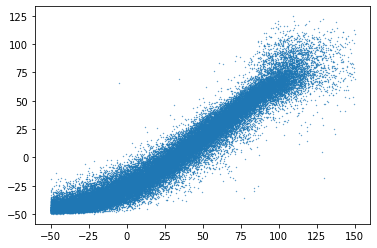

In [568]:
plt.scatter(match_dict['ae_train_mae']['z_tar'], match_dict['ae_train_mae']['z_pred'], s=0.1)

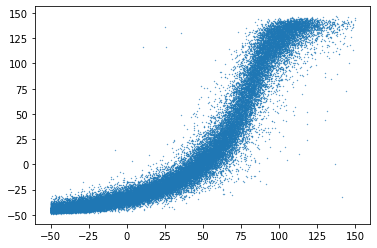

In [570]:
plt.scatter(match_dict['ae_train_noembgp']['z_tar'], match_dict['ae_train_noembgp']['z_pred'], s=0.1)

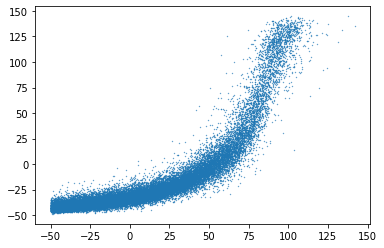

In [481]:
plt.scatter(match_dict['sl_no_learn']['z_tar'], match_dict['sl_no_learn']['z_pred'], s=0.1)

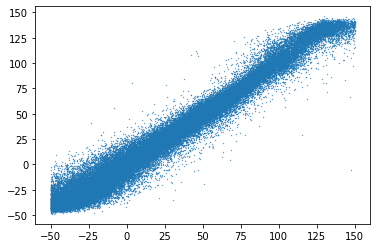

In [482]:
plt.scatter(match_dict['sl_true_gen_mae']['z_tar'], match_dict['sl_true_gen_mae']['z_pred'], s=0.1)

In [ ]:
# res_single = sel_int_ch(res_single, codebook)
metrics = ['comb_sig','tot_int','tot_int_sig', 'prob','z', 'int_ratio']
bins = [np.linspace(0,1.5,31), np.linspace(0,30,31), np.linspace(0,15,31), np.linspace(0.4,1,31), np.linspace(-50,150.,31),  np.linspace(0.,3., 31)]
plt.figure(figsize=(20,5))
for i in range(len(metrics)):
    plt.subplot(1,len(metrics),i+1)
    _=plt.hist(res_single[~res_single['class'] == 1][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='gene matches')
    _=plt.hist(res_single[res_single['class'] == 1][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='blank matches')
    plt.title(metrics[i])

(array([5432., 5244., 4836., 4115., 3450., 2824., 2030., 1247.,  145.,
           9.]),
 array([-49.99455261, -30.79353333, -11.59251404,   7.60850525,
         26.80952454,  46.01054382,  65.21156311,  84.4125824 ,
        103.61360168, 122.81462097, 142.01564026]),
 <BarContainer object of 10 artists>)

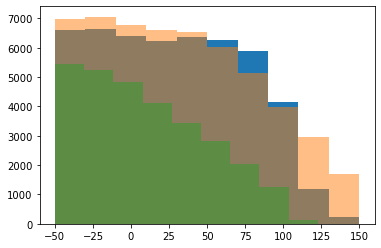

In [495]:
plt.hist(match_dict['ae_train_mae']['z_tar'])
plt.hist(match_dict['sl_true_gen_mae']['z_tar'],alpha=0.5)
plt.hist(match_dict['sl_no_learn']['z_tar'],alpha=0.5)

In [577]:
perf, matches, _ = matching(df_dict['ae_train_l1'], df_dict['sl_true_gen_mae'], print_res=True, tolerance=500, ignore_z=True)

Recall: 0.796
Precision: 0.848
Jaccard: 69.696
RMSE_vol: 51.201
Eff_3d: 60.330
FN: 12160.0 FP: 8524.0
Num. matches: 47572.000
Shift: 28.43,-11.02,-26.02


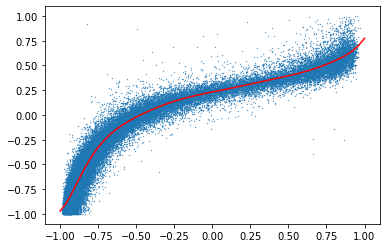

In [619]:
# get x and y vectors
y = (match_dict['ae_train_noembgp']['z_tar'].values - 50)/100
x = (match_dict['ae_train_noembgp']['z_pred'].values - 50)/100

# calculate polynomial
z = np.polyfit(x, y, 10)
f = np.poly1d(z)

# calculate new x's and y's
x_new = np.linspace(-1, 1., 50)
y_new = f(x_new)

plt.scatter(x, y, s=0.1)
plt.plot(x_new, y_new, color='red')

In [620]:
from decode_fish.engine.psf import LinearInterpolatedPSF

psf_gt = LinearInterpolatedPSF([7,21,21], n_cols=1, mode='bicubic')
psf_gt = swap_psf_vol(psf_gt, gt_psf)

In [670]:
psf_l = LinearInterpolatedPSF([11,21,21], n_cols=1, mode='bicubic')
psf_l = swap_psf_vol(psf_l, cpu(micro.psf.psf_volume[0]))
psf_ini = LinearInterpolatedPSF([11,21,21], n_cols=1, mode='bicubic')
psf_ini = swap_psf_vol(psf_ini, cpu(micro.psf_init_vol[0]))

In [671]:
zgt = torch.linspace(-1, 0.8, 100)
zgts = torch.clamp(0.5*zgt,-0.49999,0.49999) + 0.5 # transform to [0,1]
z_scaled = zgts * (7 - 2) # [0, z_size]
z_inds = (torch.div(z_scaled, 1, rounding_mode='trunc')).type(torch.cuda.LongTensor) + 1
z_os = -(z_scaled%1.) + 0.5
z_os = z_os.cuda()
z_inds = z_inds.cuda()

In [672]:
gt_stack = psf_gt.forward(z_os*0, z_os*0, z_os, z_inds, None)
gt_stack /= gt_stack.sum(dim=[3,4], keepdim=True)

In [673]:
# zl = torch.linspace(-1, 1, 100)
zl = torch.tensor(f(zgt))
zls = torch.clamp(0.5*zl,-0.49999,0.49999) + 0.5 # transform to [0,1]
z_scaled = zls * (7 - 2) # [0, z_size]
z_inds = (torch.div(z_scaled, 1, rounding_mode='trunc')).type(torch.cuda.LongTensor) + 1
z_os = -(z_scaled%1.) + 0.5
z_os = z_os.cuda()
z_inds = z_inds.cuda()

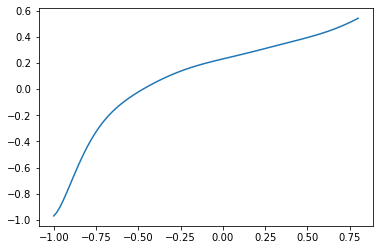

In [674]:
plt.plot(zgt,zl)

In [675]:
l_stack = psf_l.forward(z_os*0, z_os*0, z_os, z_inds, None)
l_stack /= l_stack.sum(dim=[3,4], keepdim=True)
ini_stack = psf_ini.forward(z_os*0, z_os*0, z_os, z_inds, None)
ini_stack /= ini_stack.sum(dim=[3,4], keepdim=True)

(<Figure size 886.629x843.429 with 6 Axes>,
 [<AxesSubplot:ylabel='y'>,
  <AxesSubplot:xlabel='x', ylabel='z'>,
  <AxesSubplot:xlabel='z'>])

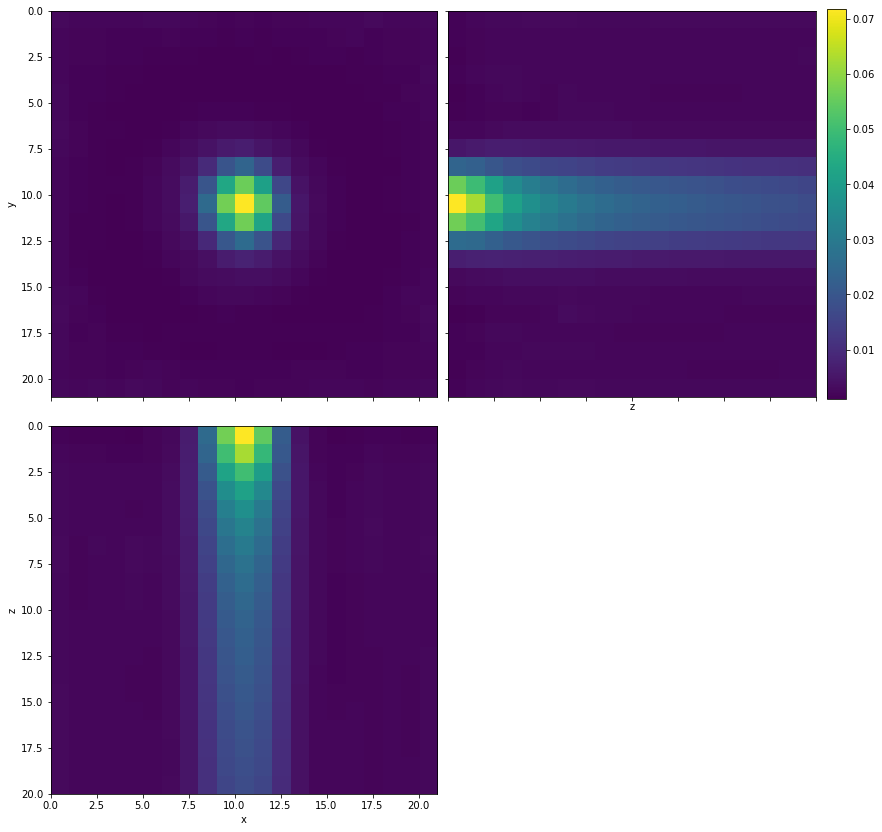

In [676]:
plot_3d_projections(l_stack[::5,0,0])

(<Figure size 886.629x843.429 with 6 Axes>,
 [<AxesSubplot:ylabel='y'>,
  <AxesSubplot:xlabel='x', ylabel='z'>,
  <AxesSubplot:xlabel='z'>])

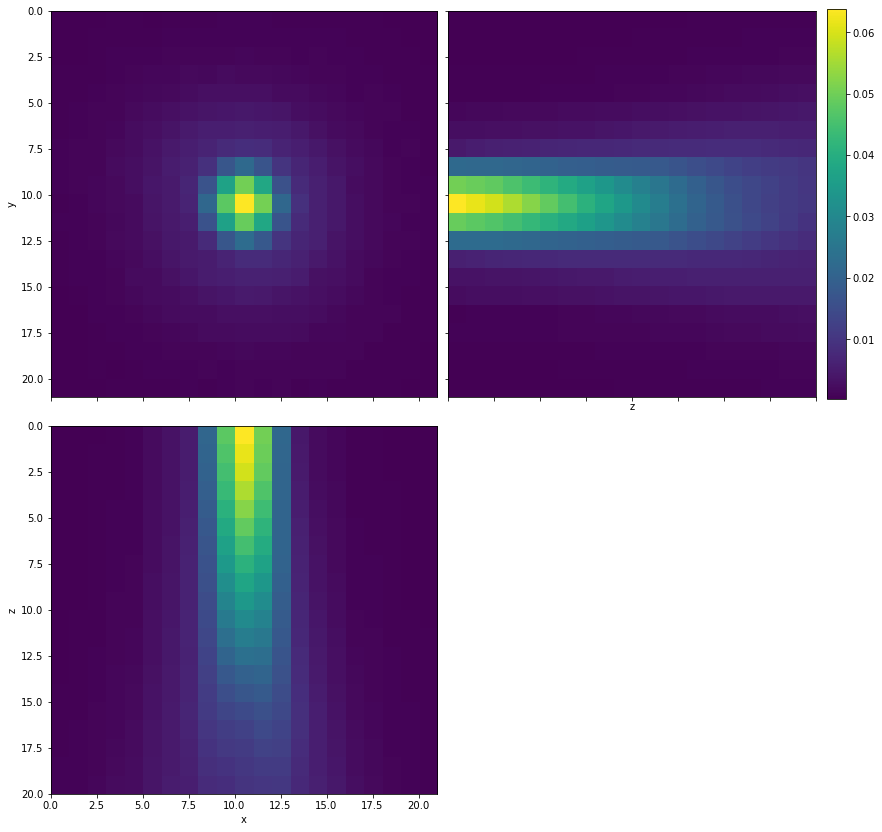

In [677]:
plot_3d_projections(gt_stack[::5,0,0])

In [678]:
torch.sqrt(torch.mean((l_stack-gt_stack)**2)) * 1000

tensor(1.6792, device='cuda:0', grad_fn=<MulBackward0>)

In [679]:
torch.sqrt(torch.mean((ini_stack-gt_stack)**2)) * 1000

tensor(2.7771, device='cuda:0', grad_fn=<MulBackward0>)

In [680]:
torch.sqrt(torch.mean((ini_stack-l_stack)**2)) * 1000

tensor(3.2371, device='cuda:0', grad_fn=<MulBackward0>)